In [1]:
# Ensure notebook is being run from base repository directory
COVID_HOME = "/Users/efua/documents/uni/spring-2021/UROP/covid19-forecast-hub"
import os, sys
try:
    os.chdir(COVID_HOME)
except Exception as err:
    print(f"Warning: unable to change directory; {repr(err)}")
from src.utils.notebook_util import isnotebook
if isnotebook():
    # Autoreload packages that are modified
    %load_ext autoreload
    %autoreload 2
else:
    from argparse import ArgumentParser
    
# Computational libraries 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy.matlib
from collections import deque

# os libraries 
import shutil
from datetime import datetime, timedelta
from functools import partial
import copy
import pdb
import os

from utils import *
from file_util import *
from attributes import *

from zoo_of_experts import *
from zoo_of_hinters import *
from zoo_of_losses import *

import matplotlib.pyplot as plt

In [11]:
#
# Specify model parameters
#
model_name = "online_expert" 

if not isnotebook():
    # If notebook run as a script, parse command-line arguments
    parser = ArgumentParser()
    parser.add_argument("pos_vars",nargs="*")  # gt_id and horizon 
    parser.add_argument('--target_dates', '-t', default="std_future")
    args, opt = parser.parse_known_args()
    
    # Assign variables                                                                                                                                     
    gt_id = get_id_name(args.pos_vars[0]) # "contest_precip" or "contest_tmp2m"                                                                            
    horizon = get_th_name(args.pos_vars[1]) # "34w" or "56w"    
    target_date_str = args.target_dates # target date object
else:
    # Otherwise, specify arguments interactively
    gt_id = "incd_death" #"contest_precip", "contest_tmp2m". choices: "cumm_death", "incd_death", "cumm_case", "incd_case"     
    target_date_str = "std_weekly" #"contest_precip", "contest_tmp2m"
    location = 'US' #US or FIPS code
    quantile = 0.5
    horizon = "1w"

In [12]:
"""
Read in ground truth and model predictions for task
"""
# Get location FIPS codes
fips_codes = get_fips_codes() 

# Read ground truth 
printf(f'Loading {gt_id} ground truth')
df_gt = get_ground_truth(gt_id, location, load_df=True)

# Get target dates
first_date, last_date = get_data_range(gt_id, location=location)
printf(f"Getting target dates from {first_date} to {last_date}.")
target_dates = get_target_dates(target_date_str, first_date, last_date)
target_date_objs = pd.Series(target_dates)

# Store delta between target date and forecast issuance date
start_delta = timedelta(days=get_start_delta(horizon, gt_id))

# Get model predicitons for the task
printf(f'Loading model predictions for {gt_id}, {horizon}, {location}, q{quantile}')
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)

# Get model list
persistant_models, all_models = get_persistant_models(model_pred_df)
expert_models = list(all_models)
expert_models.sort()
model_string = (',').join(expert_models)
printf(f"Predictions for models loaded:\n {expert_models}")

Loading incd_death ground truth
Getting target dates from 2020-01-29 00:00:00 to 2021-04-13 00:00:00.
Loading model predictions for incd_death, 1w, US, q0.5
Predictions for models loaded:
 ['BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline', 'COVIDhub-ensemble', 'COVIDhub-trained_ensemble', 'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator', 'CovidAnalytics-DELPHI', 'DDS-NBDS', 'GT-DeepCOVID', 'IHME-CurveFit', 'IUPUI-HkPrMobiDyR', 'Imperial-ensemble1', 'Imperial-ensemble2', 'IowaStateLW-STEM', 'JCB-PRM', 'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'MITCovAlliance-SIR', 'MIT_CritData-GBCF', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID', 'MSRA-DeepST', 'Microsoft-DeepSTIA', 'NotreDame-mobility', 'OliverWyman-Navigator', 'PSI-DRAFT', 'QJHong-Encounter', 'RPI_UW-Mob_Collision', 'RobertWalraven-ESG', 'SWC-TerminusCM', 'SigSci-TS', 'SteveMcConnell-CovidComple

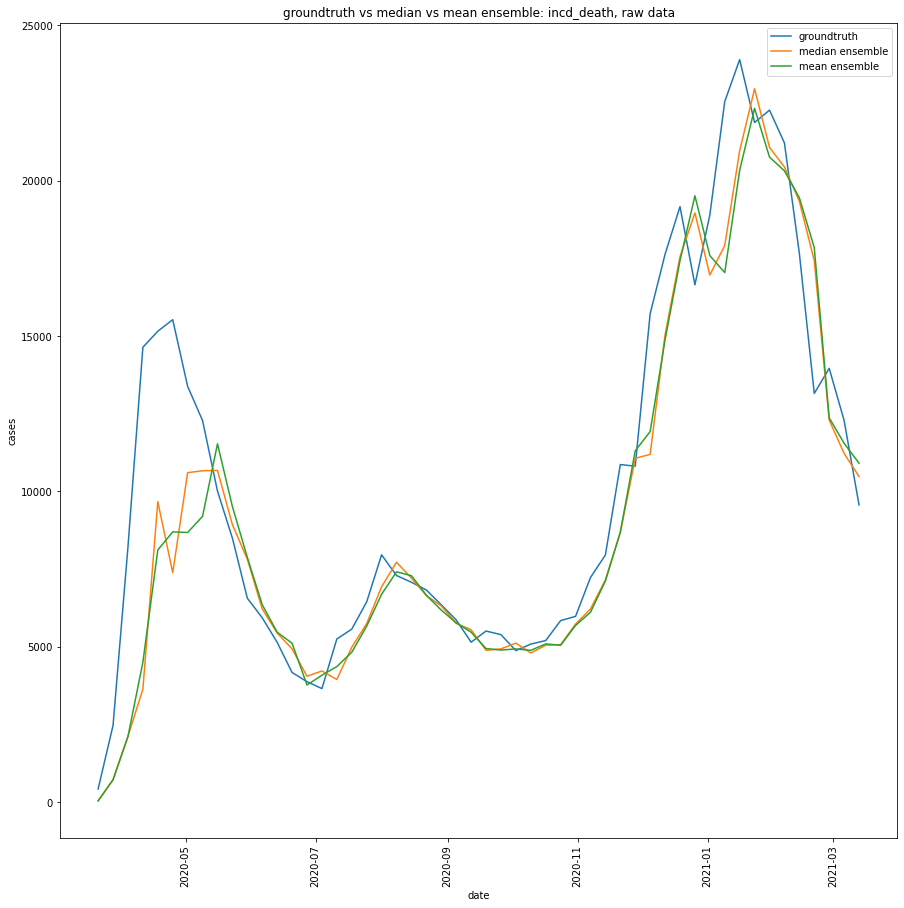

In [13]:
"""
create median and mean ensemble plots, and plot with groundtruth data
"""

GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']


med_model = model_pred_df.groupby(['target_end_date']).median() 
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

ensemble_dates = MED_xvals.tolist() 
GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
mea_model = model_pred_df.groupby(['target_end_date']).mean()
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_xvals = MEA_single['target_end_date']
MEA_yvals = MEA_single['value']
        
#combined plot of groundtruth, ensemble (median), and individual models.
plt.figure(figsize=(15,15))
plt.plot(GT_mdates, GT_mvals, label = "groundtruth")
plt.plot(GT_mdates, MED_yvals, label = "median ensemble")
plt.plot(GT_mdates, MEA_yvals, label = "mean ensemble")
plt.xticks(rotation=90)
plt.title(f'groundtruth vs median vs mean ensemble: {gt_id}, raw data')
plt.ylabel('cases')
plt.xlabel('date')
plt.legend()
plt.show()

mean overall error: 1780.073628984719

median overall error: 1669.7661514900078



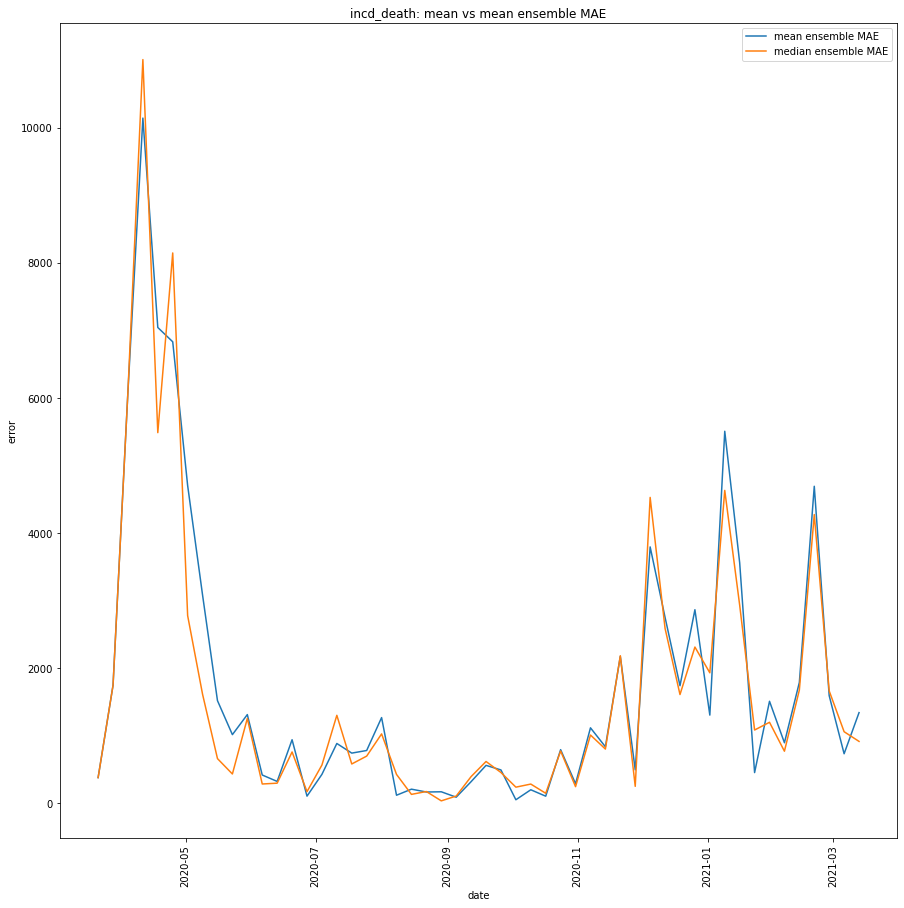

In [14]:
"""
create mean absolute error plots
"""

#make median series
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    MED_dict[row["target_end_date"]] = row["value"]

med_series = pd.Series(data=MED_dict, index=MED_single['target_end_date'])


#make mean series
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_dict = {}
for index, row in MEA_single.iterrows():
    MEA_dict[row["target_end_date"]] = row["value"]

mea_series = pd.Series(data=MEA_dict, index=MEA_single['target_end_date'])

#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_single
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_dict[datestr] = row["gt"]
        
GT_series = pd.Series(data=GT_dict, index=MED_single['target_end_date']) #matching gt values to ensemble dates due to missing dates?

#calculate cumulative overall error
losses_mea = MAELoss.loss(0,GT_series,mea_series)
entries = 0
tot = 0
for x in losses_mea:
    entries += 1
    tot += x
    
mean_avg = tot / entries
print(f"mean overall error: {mean_avg}")
print("")


losses_med = MAELoss.loss(0,GT_series,med_series)
entries2 = 0
tot2 = 0
for x in losses_med:
    entries2 += 1
    tot2 += x
    
med_avg = tot2 / entries2
print(f"median overall error: {med_avg}")
print("")

#plot losses
allDates = GT_mdates

plt.figure(figsize=(15,15))
plt.plot(allDates, losses_mea.values, label = "mean ensemble MAE")
plt.plot(allDates, losses_med.values, label = "median ensemble MAE")
plt.xticks(rotation=90)
plt.title(f'{gt_id}: mean vs mean ensemble MAE')
plt.ylabel('error')
plt.xlabel('date')
plt.legend()
plt.show()

In [15]:

"""
( inc case) create and compare individual models to GT, mean, median
"""

'\n( inc case) create and compare individual models to GT, mean, median\n'

In [16]:

pd.options.display.float_format = '{:.2f}'.format


In [18]:
model_pred_df['value']['YYG-ParamSearch']

location  target_end_date
US        2020-04-18        12883.37
          2020-04-25        12686.92
          2020-05-02        13038.09
          2020-05-09        11493.58
          2020-05-16        10676.85
          2020-05-23         9364.17
          2020-05-30         7809.45
          2020-06-06         6337.34
          2020-06-13         5467.51
          2020-06-20         4830.27
          2020-06-27         3991.10
          2020-07-04         3979.07
          2020-07-11         3509.87
          2020-07-18         4515.27
          2020-07-25         5291.36
          2020-08-01         6086.20
          2020-08-08         6980.82
          2020-08-15         7288.11
          2020-08-22         6820.48
          2020-08-29         6048.26
          2020-09-05         5652.97
          2020-09-12         5286.70
          2020-09-19         4599.29
          2020-09-26         4502.64
          2020-10-03         4754.89
          2020-10-10         4700.01
Name: value,

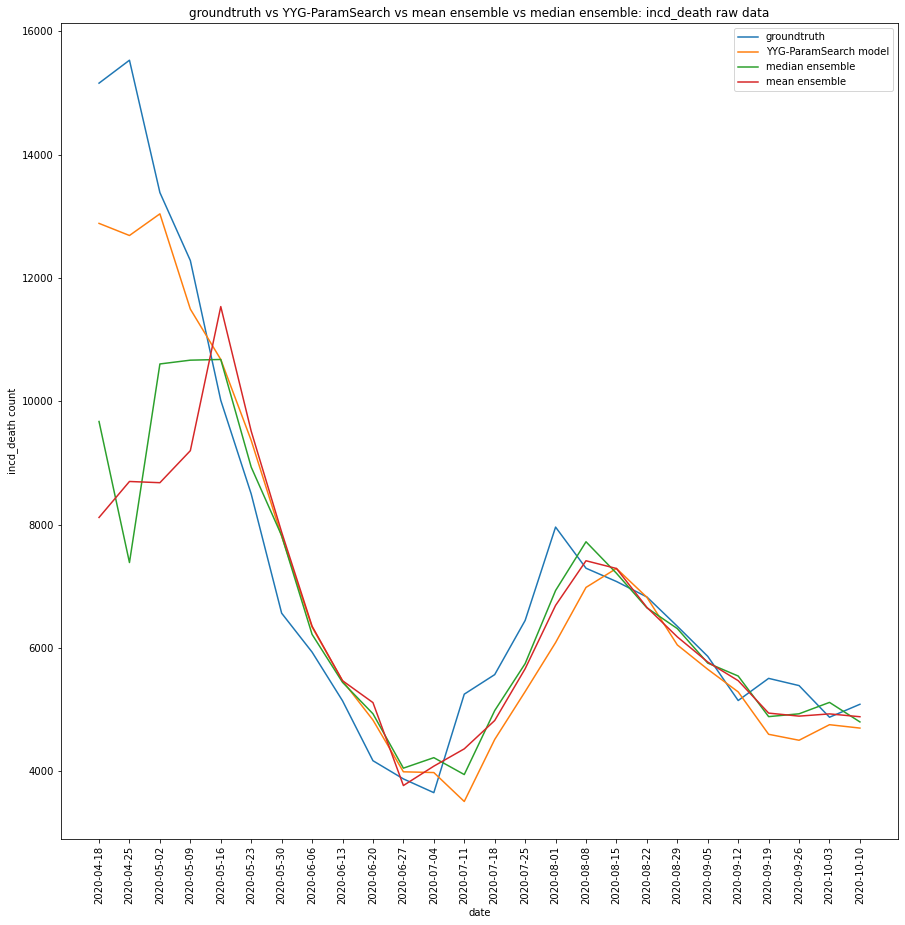

In [20]:
#------------- MODEL VS ENSEMBLE PERFORMANCE (single model)
model_choice = 'YYG-ParamSearch'
IND_model = model_pred_df['value'][model_choice]
mod_name = model_choice


#copy groundtruth data
GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']

#get model values
IND_copy  = IND_model.reset_index()
IND_xvals = IND_copy['target_end_date']
IND_yvals = IND_copy['value']
IND_dates = IND_xvals.tolist() 

#filter groundtruth to only dates in the model

GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in IND_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
#filter mean and median to model dates
med_model = model_pred_df.groupby(['target_end_date']).median() 
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

MED_mdates = []
MED_mvals = []
for index, row in MED_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    form = '{dat}'
    #datestr = date.strftime("%Y-%m-%d")
    if date in IND_dates:
        MED_mdates.append(date)
        MED_mvals.append(val)
        
mea_model = model_pred_df.groupby(['target_end_date']).mean()
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_xvals = MEA_single['target_end_date']
MEA_yvals = MEA_single['value']

MEA_mdates = []
MEA_mvals = []
for index, row in MEA_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    form = '{dat}'
    #datestr = date.strftime("%Y-%m-%d")
    if date in IND_dates:
        MEA_mdates.append(date)
        MEA_mvals.append(val)
        
#combined plot of groundtruth and individual model.
plt.figure(figsize=(15,15))
plt.plot(IND_dates, GT_mvals, label = "groundtruth")
plt.plot(IND_dates, IND_yvals, label = f"{mod_name} model")
plt.plot(IND_dates, MED_mvals, label = "median ensemble")
plt.plot(IND_dates, MEA_mvals, label = "mean ensemble")
plt.xticks(rotation=90)
plt.title(f'groundtruth vs {mod_name} vs mean ensemble vs median ensemble: {gt_id} raw data')
plt.ylabel(f'{gt_id} count')
plt.xlabel('date')
plt.legend()
plt.show()

USACE-ERDC_SEIR model overall error: 53996.95576104237

mean overall error for USACE-ERDC_SEIR date range: 61434.65826603757

median overall error for USACE-ERDC_SEIR date range: 54371.86903886101



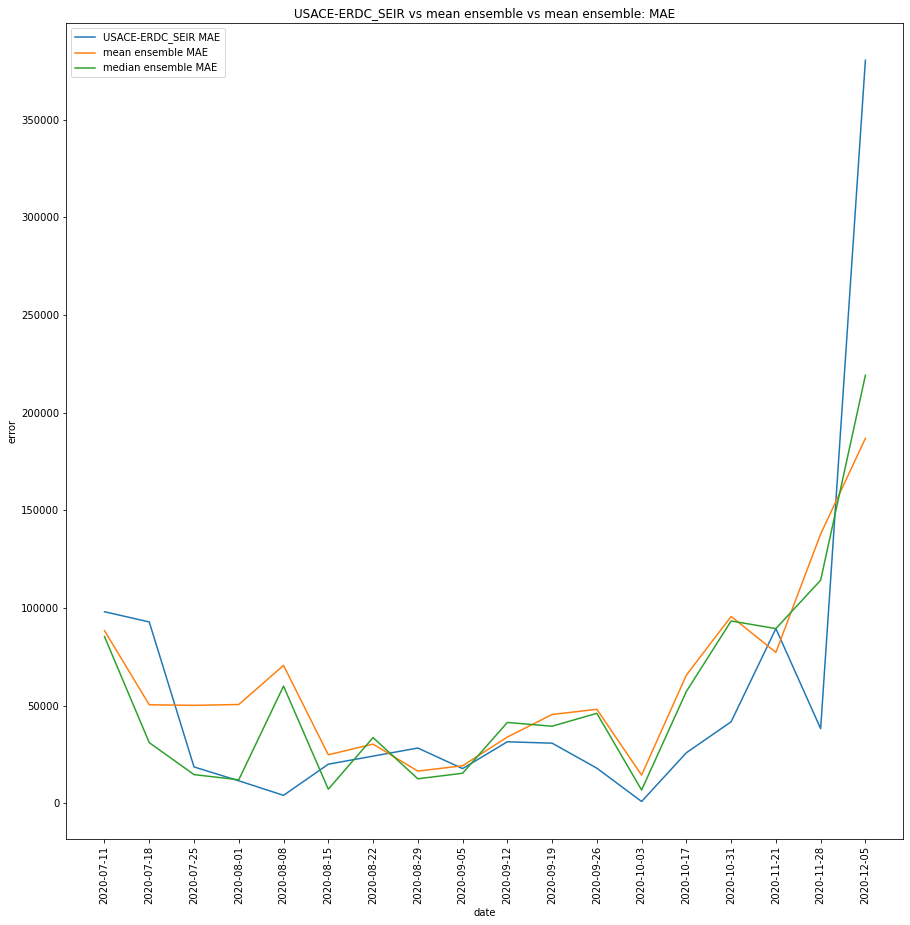

In [10]:
#------------- MODEL VS ENSEMBLE ERROR (single model)
#make model series
MOD_copy = IND_model
MOD_single = MOD_copy.reset_index()
MOD_dict = {}
for index, row in MOD_single.iterrows():
    MOD_dict[row["target_end_date"]] = row["value"]

mod_series = pd.Series(data=MOD_dict, index=MOD_single['target_end_date'])

#make median series
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    dat = row["target_end_date"]
    if dat in IND_dates:
        MED_dict[dat] = row["value"]

med_series = pd.Series(data=MED_dict, index=MOD_single['target_end_date'])


#make mean series
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_dict = {}
for index, row in MEA_single.iterrows():
    dat = row["target_end_date"]
    if dat in IND_dates:
        MEA_dict[dat] = row["value"]

mea_series = pd.Series(data=MEA_dict, index=MOD_single['target_end_date'])


#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in IND_dates:
        GT_dict[datestr] = row["gt"]
        
GT_series = pd.Series(data=GT_dict, index=MOD_single['target_end_date'])

#calculate cumulative overall errors
losses_mod = MAELoss.loss(0,GT_series,mod_series)
entries = 0
tot = 0
for x in losses_mod:
    entries += 1
    tot += x
    
mod_avg = tot / entries
print(f"{mod_name} model overall error: {mod_avg}")
print("")

losses_mea = MAELoss.loss(0,GT_series,mea_series)
entries = 0
tot = 0
for x in losses_mea:
    entries += 1
    tot += x
    
mean_avg = tot / entries
print(f"mean overall error for {mod_name} date range: {mean_avg}")
print("")


losses_med = MAELoss.loss(0,GT_series,med_series)
entries2 = 0
tot2 = 0
for x in losses_med:
    entries2 += 1
    tot2 += x
    
med_avg = tot2 / entries2
print(f"median overall error for {mod_name} date range: {med_avg}")
print("")

#plot losses
modDates = IND_dates

plt.figure(figsize=(15,15))
plt.plot(modDates, losses_mod.values, label = f"{mod_name} MAE")
plt.plot(modDates, losses_mea.values, label = "mean ensemble MAE")
plt.plot(modDates, losses_med.values, label = "median ensemble MAE")
plt.xticks(rotation=90)
plt.title(f'{mod_name} vs mean ensemble vs mean ensemble: MAE')
plt.ylabel('error')
plt.xlabel('date')
plt.legend()
plt.show()


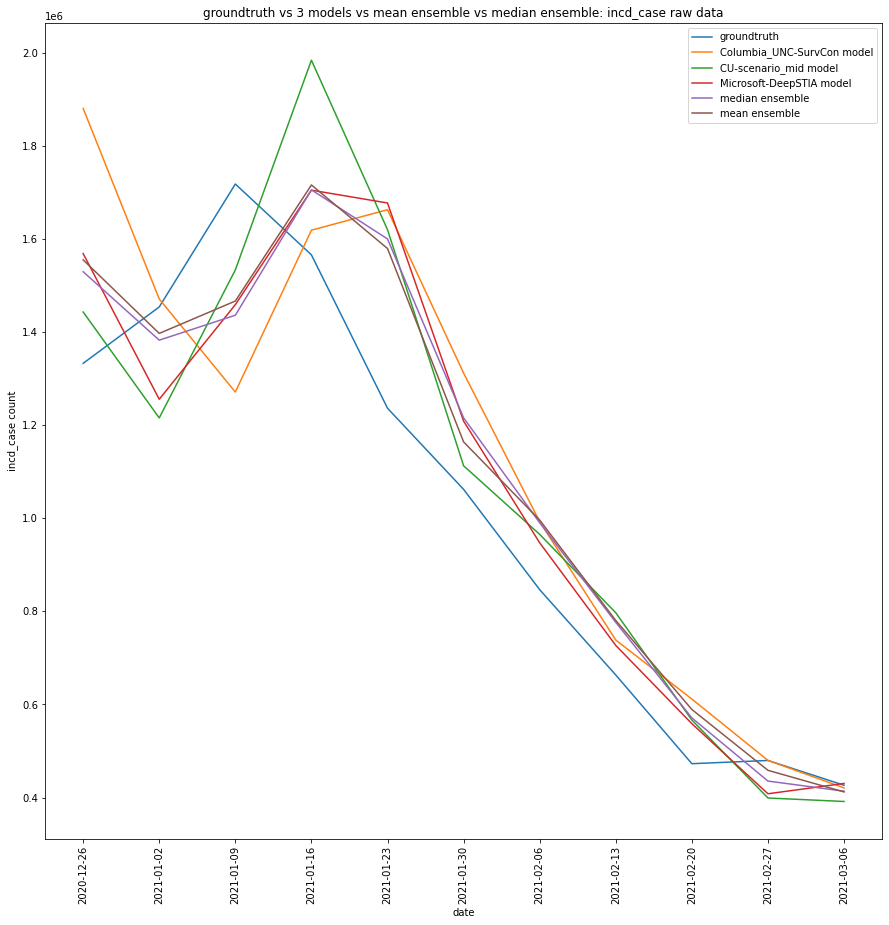

In [12]:
#------------- MODELS VS ENSEMBLE PERFORMANCE (3 IND MODELS)
IND_model_1 = model_pred_df['value']['Columbia_UNC-SurvCon']
mod1_name = 'Columbia_UNC-SurvCon'
IND_model_2 = model_pred_df['value']['CU-scenario_mid']
mod2_name = 'CU-scenario_mid'
IND_model_3 = model_pred_df['value']['Microsoft-DeepSTIA']
mod3_name = 'Microsoft-DeepSTIA'


#copy groundtruth data
GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']
GT_dates = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    datestr = date.strftime("%Y-%m-%d")
    GT_dates.append(datestr)
    
#get median ensemble values
med_model = model_pred_df.groupby(['target_end_date']).median() 
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

#get mean ensemble values
mea_model = model_pred_df.groupby(['target_end_date']).mean()
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_xvals = MEA_single['target_end_date']
MEA_yvals = MEA_single['value']

#get model 1 values
IND_model_1_copy  = IND_model_1.reset_index()
IND1_xvals = IND_model_1_copy['target_end_date']
IND1_yvals = IND_model_1_copy['value']
IND1_dates = IND1_xvals.tolist() 

#get model 2 values
IND_model_2_copy  = IND_model_2.reset_index()
IND2_xvals = IND_model_2_copy['target_end_date']
IND2_yvals = IND_model_2_copy['value']
IND2_dates = IND2_xvals.tolist() 

#get model 3 values
IND_model_3_copy  = IND_model_3.reset_index()
IND3_xvals = IND_model_3_copy['target_end_date']
IND3_yvals = IND_model_3_copy['value']
IND3_dates = IND3_xvals.tolist() 

#find largest range of dates
mod_dates = [IND1_dates, IND2_dates, IND3_dates]
max_dates = max([len(datelist) for datelist in mod_dates])
most_dates = [datelist for datelist in mod_dates if len(datelist) == max_dates][0]

largest_range = []
for date in most_dates:
    if (date in IND1_dates) and (date in IND2_dates) and (date in IND3_dates):
        largest_range.append(date)
        
#filter Gt, mean, median, and model vals to largest range found   
IND1_xvals_filter = []
for index, row in IND_model_1_copy.iterrows():
    date = row['target_end_date']
    val = row['value']
    if date in largest_range:
        IND1_xvals_filter.append(val)
        
IND2_xvals_filter = []
for index, row in IND_model_2_copy.iterrows():
    date = row['target_end_date']
    val = row['value']
    if date in largest_range:
        IND2_xvals_filter.append(val)
        
IND3_xvals_filter = []
for index, row in IND_model_3_copy.iterrows():
    date = row['target_end_date']
    val = row['value']
    if date in largest_range:
        IND3_xvals_filter.append(val)
        
GT_filter = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in largest_range:
        GT_filter.append(val)
        
median_filter = []
for index, row in MED_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    if date in largest_range:
        median_filter.append(val)

mean_filter = []
for index, row in MEA_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    if date in largest_range:
        mean_filter.append(val)
        
        
#combined plot of groundtruth, ensembles, and individual models for largest range.
plt.figure(figsize=(15,15))
plt.plot(largest_range, GT_filter, label = "groundtruth")
plt.plot(largest_range, IND1_xvals_filter, label = f"{mod1_name} model")
plt.plot(largest_range, IND2_xvals_filter, label = f"{mod2_name} model")
plt.plot(largest_range, IND3_xvals_filter, label = f"{mod3_name} model")
plt.plot(largest_range, median_filter, label = "median ensemble")
plt.plot(largest_range, mean_filter, label = "mean ensemble")
plt.xticks(rotation=90)
plt.title(f'groundtruth vs 3 models vs mean ensemble vs median ensemble: {gt_id} raw data')
plt.ylabel(f'{gt_id} count')
plt.xlabel('date')
plt.legend()
plt.show()

Columbia_UNC-SurvCon model overall error: 191471.9090909091

CU-scenario_mid model overall error: 167908.18181818182

Microsoft-DeepSTIA model overall error: 158627.51765132506

mean overall error for UpstateSU-GRU date range: 140379.36975160884

median overall error for largest date range: 147178.35510347105



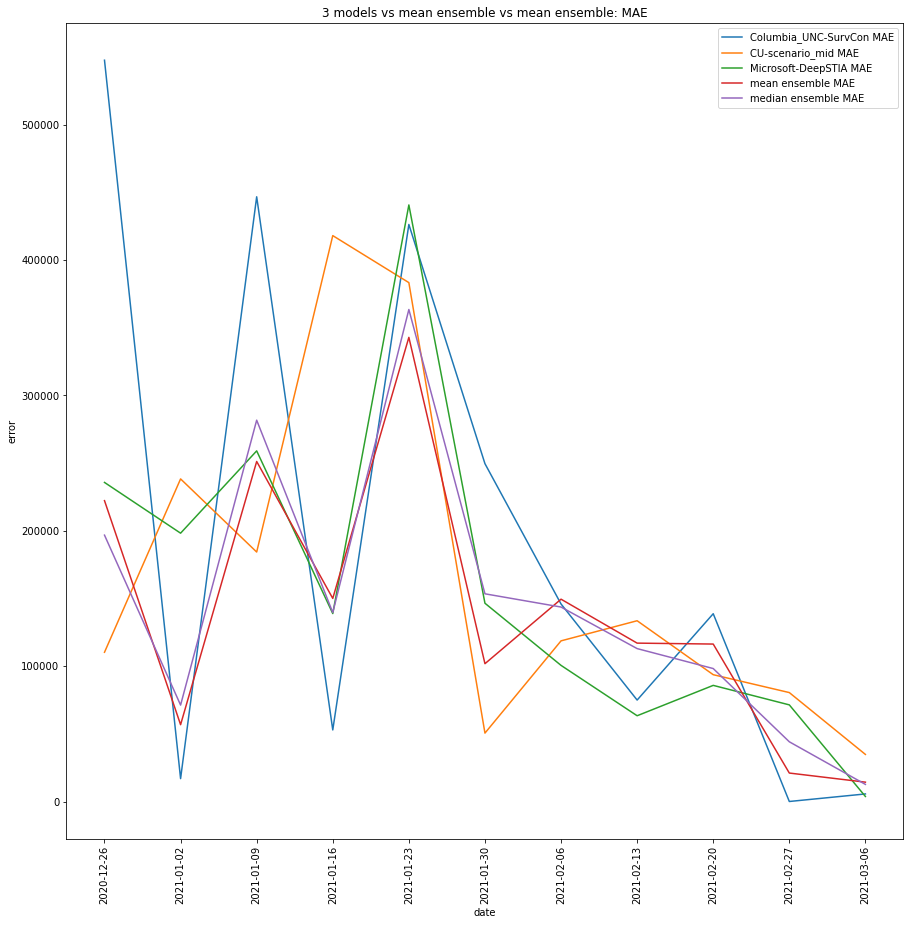

In [13]:
#------------- MODEL VS ENSEMBLE ERROR (3 models)
#make model 1 seriess
MOD1_copy = IND_model_1
MOD1_single = MOD1_copy.reset_index()
MOD1_dict = {}
for index, row in MOD1_single.iterrows():
    dat = row["target_end_date"]
    if dat in largest_range:
        MOD1_dict[dat] = row["value"]
mod1_series = pd.Series(data=MOD1_dict, index=largest_range)

#make model 2 seriess
MOD2_copy = IND_model_2
MOD2_single = MOD2_copy.reset_index()
MOD2_dict = {}
for index, row in MOD2_single.iterrows():
    dat = row["target_end_date"]
    if dat in largest_range:
        MOD2_dict[dat] = row["value"]
mod2_series = pd.Series(data=MOD2_dict, index=largest_range)

#make model 3 seriess
MOD3_copy = IND_model_3
MOD3_single = MOD3_copy.reset_index()
MOD3_dict = {}
for index, row in MOD3_single.iterrows():
    dat = row["target_end_date"]
    if dat in largest_range:
        MOD3_dict[dat] = row["value"]
mod3_series = pd.Series(data=MOD3_dict, index=largest_range)

#make median series
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    dat = row["target_end_date"]
    if dat in largest_range:
        MED_dict[dat] = row["value"]
med_series = pd.Series(data=MED_dict, index=largest_range)

#make mean series
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_dict = {}
for index, row in MEA_single.iterrows():
    dat = row["target_end_date"]
    if dat in largest_range:
        MEA_dict[dat] = row["value"]
mea_series = pd.Series(data=MEA_dict, index=largest_range)

#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in largest_range:
        GT_dict[datestr] = row["gt"]
GT_series = pd.Series(data=GT_dict, index=largest_range)

#calculate cumulative overall errors
losses_mod1 = MAELoss.loss(0,GT_series, mod1_series)
entries = 0
tot = 0
for x in losses_mod1:
    entries += 1
    tot += x
    
mod1_avg = tot / entries
print(f"{mod1_name} model overall error: {mod1_avg}")
print("")

losses_mod2 = MAELoss.loss(0,GT_series, mod2_series)
entries = 0
tot = 0
for x in losses_mod2:
    entries += 1
    tot += x
    
mod2_avg = tot / entries
print(f"{mod2_name} model overall error: {mod2_avg}")
print("")

losses_mod3 = MAELoss.loss(0,GT_series, mod3_series)
entries = 0
tot = 0
for x in losses_mod3:
    entries += 1
    tot += x
    
mod3_avg = tot / entries
print(f"{mod3_name} model overall error: {mod3_avg}")
print("")


losses_mea = MAELoss.loss(0,GT_series,mea_series)
entries = 0
tot = 0
for x in losses_mea:
    entries += 1
    tot += x
    
mean_avg = tot / entries
print(f"mean overall error for largest date range: {mean_avg}")
print("")


losses_med = MAELoss.loss(0,GT_series,med_series)
entries2 = 0
tot2 = 0
for x in losses_med:
    entries2 += 1
    tot2 += x
    
med_avg = tot2 / entries2
print(f"median overall error for largest date range: {med_avg}")
print("")

#plot losses
modDates = largest_range

plt.figure(figsize=(15,15))
plt.plot(modDates, losses_mod1.values, label = f"{mod1_name} MAE")
plt.plot(modDates, losses_mod2.values, label = f"{mod2_name} MAE")
plt.plot(modDates, losses_mod3.values, label = f"{mod3_name} MAE")
plt.plot(modDates, losses_mea.values, label = "mean ensemble MAE")
plt.plot(modDates, losses_med.values, label = "median ensemble MAE")
plt.xticks(rotation=90)
plt.title(f'3 models vs mean ensemble vs mean ensemble: MAE')
plt.ylabel('error')
plt.xlabel('date')
plt.legend()
plt.show()


In [14]:
"""
( inc death) create and compare individual models to GT, mean, median
"""

'\n( inc death) create and compare individual models to GT, mean, median\n'

In [15]:
#------------------------YYG model

#copy groundtruth data
GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']

#get model values
YYG_model = model_pred_df['value']['YYG-ParamSearch']
YYG_copy  = YYG_model.reset_index()
YYG_xvals = YYG_copy['target_end_date']
YYG_yvals = YYG_copy['value']

ensemble_dates = YYG_xvals.tolist() 

#filter groundtruth to only dates in the model
GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
#filter mean and median to model dates
med_model = model_pred_df.groupby(['target_end_date']).median() 
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

MED_mdates = []
MED_mvals = []
for index, row in MED_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    form = '{dat}'
    #datestr = date.strftime("%Y-%m-%d")
    if date in ensemble_dates:
        MED_mdates.append(date)
        MED_mvals.append(val)
        
mea_model = model_pred_df.groupby(['target_end_date']).mean()
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_xvals = MEA_single['target_end_date']
MEA_yvals = MEA_single['value']

MEA_mdates = []
MEA_mvals = []
for index, row in MEA_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    form = '{dat}'
    #datestr = date.strftime("%Y-%m-%d")
    if date in ensemble_dates:
        MEA_mdates.append(date)
        MEA_mvals.append(val)
        
#combined plot of groundtruth and individual model (YYG) for YYG dates.
plt.figure(figsize=(15,15))
plt.plot(GT_mdates, GT_mvals, label = "groundtruth")
plt.plot(GT_mdates, YYG_yvals, label = "YYG model")
plt.plot(GT_mdates, MED_mvals, label = "median ensemble")
plt.plot(GT_mdates, MEA_mvals, label = "mean ensemble")
plt.xticks(rotation=90)
plt.title('groundtruth vs YYG model: incident deaths, raw data')
plt.ylabel('deaths')
plt.xlabel('date')
plt.legend()
plt.show()

KeyError: 'YYG-ParamSearch'

In [ ]:
#------------------------YYG model (error)

#make model series
MOD_copy = YYG_model
MOD_single = MOD_copy.reset_index()
MOD_dict = {}
for index, row in MOD_single.iterrows():
    MOD_dict[row["target_end_date"]] = row["value"]

mod_series = pd.Series(data=MOD_dict, index=MOD_single['target_end_date'])

#make median series
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    dat = row["target_end_date"]
    if dat in ensemble_dates:
        MED_dict[dat] = row["value"]

med_series = pd.Series(data=MED_dict, index=MOD_single['target_end_date'])


#make mean series
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_dict = {}
for index, row in MEA_single.iterrows():
    dat = row["target_end_date"]
    if dat in ensemble_dates:
        MEA_dict[dat] = row["value"]

mea_series = pd.Series(data=MEA_dict, index=MOD_single['target_end_date'])


#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_dict[datestr] = row["gt"]
        
GT_series = pd.Series(data=GT_dict, index=MOD_single['target_end_date'])

#calculate cumulative overall errors
losses_mod = MAELoss.loss(0,GT_series,mod_series)
entries = 0
tot = 0
for x in losses_mod:
    entries += 1
    tot += x
    
mod_avg = tot / entries
print(f"model overall error: {mod_avg}")
print("")

losses_mea = MAELoss.loss(0,GT_series,mea_series)
entries = 0
tot = 0
for x in losses_mea:
    entries += 1
    tot += x
    
mean_avg = tot / entries
print(f"mean overall error: {mean_avg}")
print("")


losses_med = MAELoss.loss(0,GT_series,med_series)
entries2 = 0
tot2 = 0
for x in losses_med:
    entries2 += 1
    tot2 += x
    
med_avg = tot2 / entries2
print(f"median overall error: {med_avg}")
print("")

#plot losses
modDates = ensemble_dates

plt.figure(figsize=(15,15))
plt.plot(modDates, losses_mod.values, label = "YYG model MAE")
plt.plot(modDates, losses_mea.values, label = "mean ensemble MAE")
plt.plot(modDates, losses_med.values, label = "median ensemble MAE")
plt.xticks(rotation=90)
plt.title('YYG model vs mean vs median ensemble: MAE')
plt.ylabel('error')
plt.xlabel('date')
plt.legend()
plt.show()

In [ ]:
#------------------------Microsoft-DeepSTIA model

#copy groundtruth data
GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']

#get model values
STIA_model = model_pred_df['value']['Microsoft-DeepSTIA']
STIA_copy  = STIA_model.reset_index()
STIA_xvals = STIA_copy['target_end_date']
STIA_yvals = STIA_copy['value']

#filter groundtruth to only dates in the model
ensemble_dates = STIA_xvals.tolist() 
GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
#filter mean and median to model dates
med_model = model_pred_df.groupby(['target_end_date']).median() 
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

ensemble_dates =STIA_xvals.tolist() 
MED_mdates = []
MED_mvals = []
for index, row in MED_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    form = '{dat}'
    #datestr = date.strftime("%Y-%m-%d")
    if date in ensemble_dates:
        MED_mdates.append(date)
        MED_mvals.append(val)
        
mea_model = model_pred_df.groupby(['target_end_date']).mean()
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_xvals = MEA_single['target_end_date']
MEA_yvals = MEA_single['value']


ensemble_dates = STIA_xvals.tolist() 
MEA_mdates = []
MEA_mvals = []
for index, row in MEA_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    form = '{dat}'
    #datestr = date.strftime("%Y-%m-%d")
    if date in ensemble_dates:
        MEA_mdates.append(date)
        MEA_mvals.append(val)
        
#combined plot of groundtruth and individual model (STIA) for STIA dates.
plt.figure(figsize=(15,15))
plt.plot(GT_mdates, GT_mvals, label = "groundtruth")
plt.plot(GT_mdates, STIA_yvals, label = "Microsoft STIA model")
plt.plot(GT_mdates, MED_mvals, label = "median ensemble")
plt.plot(GT_mdates, MEA_mvals, label = "mean ensemble")
plt.xticks(rotation=90)
plt.title(f'groundtruth vs Microsoft STIA model vs mean ensemble vs median ensemble: incident deaths, raw data')
plt.ylabel('deaths')
plt.xlabel('date')
plt.legend()
plt.show()

In [ ]:
#------------------------Microsoft-DeepSTIA model (error)
#make model series
MOD_copy = STIA_model
MOD_single = MOD_copy.reset_index()
MOD_dict = {}
for index, row in MOD_single.iterrows():
    MOD_dict[row["target_end_date"]] = row["value"]

mod_series = pd.Series(data=MOD_dict, index=MOD_single['target_end_date'])

#make median series
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    dat = row["target_end_date"]
    if dat in ensemble_dates:
        MED_dict[dat] = row["value"]

med_series = pd.Series(data=MED_dict, index=MOD_single['target_end_date'])


#make mean series
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_dict = {}
for index, row in MEA_single.iterrows():
    dat = row["target_end_date"]
    if dat in ensemble_dates:
        MEA_dict[dat] = row["value"]

mea_series = pd.Series(data=MEA_dict, index=MOD_single['target_end_date'])


#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_dict[datestr] = row["gt"]
        
GT_series = pd.Series(data=GT_dict, index=MOD_single['target_end_date'])

#calculate cumulative overall errors
losses_mod = MAELoss.loss(0,GT_series,mod_series)
entries = 0
tot = 0
for x in losses_mod:
    entries += 1
    tot += x
    
mod_avg = tot / entries
print(f"model overall error: {mod_avg}")
print("")

losses_mea = MAELoss.loss(0,GT_series,mea_series)
entries = 0
tot = 0
for x in losses_mea:
    entries += 1
    tot += x
    
mean_avg = tot / entries
print(f"mean overall error: {mean_avg}")
print("")


losses_med = MAELoss.loss(0,GT_series,med_series)
entries2 = 0
tot2 = 0
for x in losses_med:
    entries2 += 1
    tot2 += x
    
med_avg = tot2 / entries2
print(f"median overall error: {med_avg}")
print("")

#plot losses
modDates = ensemble_dates

plt.figure(figsize=(15,15))
plt.plot(modDates, losses_mod.values, label = "STIA model MAE")
plt.plot(modDates, losses_mea.values, label = "mean ensemble MAE")
plt.plot(modDates, losses_med.values, label = "median ensemble MAE")
plt.xticks(rotation=90)
plt.title('mean vs mean ensemble: MAE')
plt.ylabel('error')
plt.xlabel('date')
plt.legend()
plt.show()

In [ ]:
#------------------------ MITCovAlliance-SIR model 

IND_model = model_pred_df['value']['MITCovAlliance-SIR']
mod_name = 'MITCovAlliance-SIR'

#copy groundtruth data
GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']

#get model values
IND_copy  = IND_model.reset_index()
IND_xvals = IND_copy['target_end_date']
IND_yvals = IND_copy['value']
IND_dates = IND_xvals.tolist() 

#filter groundtruth to only dates in the model

GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in IND_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
#filter mean and median to model dates
med_model = model_pred_df.groupby(['target_end_date']).median() 
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

MED_mdates = []
MED_mvals = []
for index, row in MED_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    form = '{dat}'
    #datestr = date.strftime("%Y-%m-%d")
    if date in IND_dates:
        MED_mdates.append(date)
        MED_mvals.append(val)
        
mea_model = model_pred_df.groupby(['target_end_date']).mean()
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_xvals = MEA_single['target_end_date']
MEA_yvals = MEA_single['value']

MEA_mdates = []
MEA_mvals = []
for index, row in MEA_single.iterrows():
    date = row["target_end_date"]
    val = row["value"]
    form = '{dat}'
    #datestr = date.strftime("%Y-%m-%d")
    if date in IND_dates:
        MEA_mdates.append(date)
        MEA_mvals.append(val)
        
#combined plot of groundtruth and individual model.
plt.figure(figsize=(15,15))
plt.plot(IND_dates, GT_mvals, label = "groundtruth")
plt.plot(IND_dates, IND_yvals, label = f"{mod_name} model")
plt.plot(IND_dates, MED_mvals, label = "median ensemble")
plt.plot(IND_dates, MEA_mvals, label = "mean ensemble")
plt.xticks(rotation=90)
plt.title(f'groundtruth vs {mod_name} vs mean ensemble vs median ensemble: incident deaths, raw data')
plt.ylabel('deaths')
plt.xlabel('date')
plt.legend()
plt.show()

In [ ]:
#------------------------model (error)
#make model series
MOD_copy = IND_model
MOD_single = MOD_copy.reset_index()
MOD_dict = {}
for index, row in MOD_single.iterrows():
    MOD_dict[row["target_end_date"]] = row["value"]

mod_series = pd.Series(data=MOD_dict, index=MOD_single['target_end_date'])

#make median series
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    dat = row["target_end_date"]
    if dat in IND_dates:
        MED_dict[dat] = row["value"]

med_series = pd.Series(data=MED_dict, index=MOD_single['target_end_date'])


#make mean series
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_dict = {}
for index, row in MEA_single.iterrows():
    dat = row["target_end_date"]
    if dat in IND_dates:
        MEA_dict[dat] = row["value"]

mea_series = pd.Series(data=MEA_dict, index=MOD_single['target_end_date'])


#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in IND_dates:
        GT_dict[datestr] = row["gt"]
        
GT_series = pd.Series(data=GT_dict, index=MOD_single['target_end_date'])

#calculate cumulative overall errors
losses_mod = MAELoss.loss(0,GT_series,mod_series)
entries = 0
tot = 0
for x in losses_mod:
    entries += 1
    tot += x
    
mod_avg = tot / entries
print(f"{mod_name} model overall error: {mod_avg}")
print("")

losses_mea = MAELoss.loss(0,GT_series,mea_series)
entries = 0
tot = 0
for x in losses_mea:
    entries += 1
    tot += x
    
mean_avg = tot / entries
print(f"mean overall error for {mod_name} date range: {mean_avg}")
print("")


losses_med = MAELoss.loss(0,GT_series,med_series)
entries2 = 0
tot2 = 0
for x in losses_med:
    entries2 += 1
    tot2 += x
    
med_avg = tot2 / entries2
print(f"median overall error for {mod_name} date range: {med_avg}")
print("")

#plot losses
modDates = IND_dates

plt.figure(figsize=(15,15))
plt.plot(modDates, losses_mod.values, label = f"{mod_name} MAE")
plt.plot(modDates, losses_mea.values, label = "mean ensemble MAE")
plt.plot(modDates, losses_med.values, label = "median ensemble MAE")
plt.xticks(rotation=90)
plt.title(f'{mod_name} vs mean ensemble vs mean ensemble: MAE')
plt.ylabel('error')
plt.xlabel('date')
plt.legend()
plt.show()

In [ ]:
"""
FIPS conversion: hard coded version
"""
#abbreviation to fips, hard code ver.
locCode = 0;
def FIPSconvert(entry):
    FIPSdict = {
        "US": "US",
        "AL": 1,
        "AK": 2,
        "AZ": 4,
        "AR": 5,
        "CA": 6,
        "CO": 8,
        "CT": 9,
        "DE": 10,
        "DC": 11,
        "FL": 12,
        "GA": 13,
        "HI": 15,
        "ID": 16,
        "IL": 17,
        "IN": 18,
        "IA": 19,
        "KS": 20,
        "KY": 21,
        "LA": 22,
        "ME": 23,
        "MD": 24,
        "MA": 25,
        "MI": 26,
        "MN": 27,
        "MS": 28,
        "MO": 29,
        "MT": 30,
        "NE": 31,
        "NV": 32,
        "NH": 33,
        "NJ": 34,
        "NM": 35,
        "NY": 36,
        "NC": 37,
        "ND": 38,
        "OH": 39,
        "OK": 40,
        "OR": 41,
        "PA": 42,
        "RI": 44,
        "SC": 45,
        "SD": 46,
        "TN": 47,
        "TX": 48,
        "UT": 49,
        "VT": 50,
        "VA": 51,
        "WA": 53,
        "WV": 54,
        "WI": 55,
        "WY": 56,
        "AS": 60,
        "GU": 66,
        "MP": 69,
        "PR": 72,
        "UM": 74,
        "VI": 78,
    }
    
    if entry in FIPSdict:
        locCode = FIPSdict.get(entry)
        print(f"{entry} is {locCode}")
        
FIPSconvert("PR")
